In [1]:
import pandas as pd

In [2]:
loss_history = pd.read_parquet('/Users/nicknielsen/Downloads/synthetic_data.parquet')

In [3]:
loss_history

,date,outcome_of_int
0,2017-01-03,186756.182711
1,2017-01-04,15547.953488
2,2017-01-04,25400.366395
3,2017-01-04,8031.089038
4,2017-01-04,6272.543590
...,...,...
1995,2021-12-29,2.810434
1996,2021-12-29,561.770233
1997,2021-12-30,88044.150849
1998,2021-12-30,668.220446


In [4]:
loss_history.date.max()

'2021-12-30'

In [5]:
loss_history.to_csv('synthetic_data.csv', index=False)

In [6]:
df = loss_history

In [7]:
df.isnull().sum()

date              0
outcome_of_int    0
dtype: int64

In [8]:
df[df['outcome_of_int'] <= 0]

,date,outcome_of_int


In [9]:
df['date'].min(), df['date'].max()

('2017-01-03', '2021-12-30')

In [10]:
df.duplicated().sum()

0

In [11]:
daily = df.groupby("date")["outcome_of_int"].sum()
daily[daily > daily.quantile(0.999)]  # extreme outliers


date
2021-02-12    5.520345e+07
Name: outcome_of_int, dtype: float64

In [12]:
df = df.sort_values("date")
assert df["date"].is_monotonic_increasing


In [13]:
df['date'].value_counts().describe()


count    575.000000
mean       3.478261
std        7.090441
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       96.000000
Name: count, dtype: float64

In [14]:
df['outcome_of_int'].skew(), df['outcome_of_int'].kurt()


(17.80097645253547, 371.4903079648194)

<Axes: xlabel='date'>

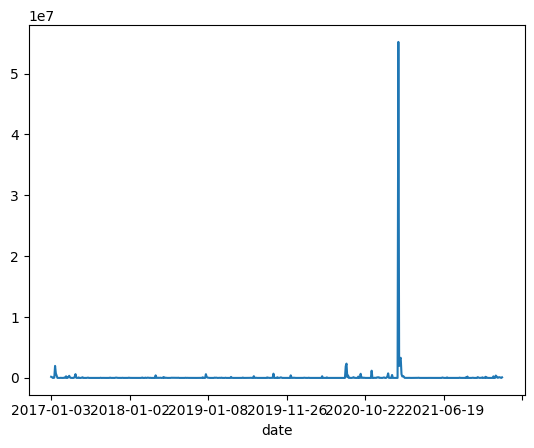

In [15]:
df.groupby('date').outcome_of_int.sum().plot()

In [16]:
loss_by_date = df.groupby('date').outcome_of_int.sum()

In [17]:
loss_by_date.index = pd.DatetimeIndex(loss_by_date.index)

In [18]:
DATE_COL = 'DATE'

def load_observations(file_name):
    obs = pd.read_csv(f'/Users/nicknielsen/Downloads/{file_name}')
    obs.index = pd.to_datetime(obs.loc[:, DATE_COL])
    obs = obs.sort_index(ascending=True)

    return obs

In [173]:
observation_files_by_station = {
    'KPDX': 'portland_observations.csv',
    'KSLE': 'salem_observations.csv'
}

obs_by_station = {
    station: load_observations(file)
    for station, file in observation_files_by_station.items()
}

In [174]:
base_features = [
 'DEWP',
 'FRSHTT',
 'GUST',
 'MAX',
 'MIN',
 'MXSPD',
 'PRCP',
 'SLP',
 'SNDP',
 'STP',
 'TEMP',
 'VISIB',
 'WDSP'
]
window_days = [
    3,
    7,
    14,
    30
]
rolling_mean_suffix = 'd_mean'

def compute_additional_features(obs):
    for f in base_features:
        for d in window_days:
            new_feature = f'{f}_{d}{rolling_mean_suffix}'
            obs[new_feature] = obs[f].rolling(window=d, min_periods=1).mean()
    return obs

In [175]:
obs_by_station = {
    station: compute_additional_features(load_observations(file))
    for station, file in observation_files_by_station.items()
}

In [178]:
p = obs_by_station['KPDX']
s = obs_by_station['KSLE']

In [168]:
filtered = p.loc[:, [c for c in p.columns if c in base_features or rolling_mean_suffix in c]]

In [248]:
def combine_obs_with_outcome(obs_by_station, outcome):
    outcome.sort_index(ascending=True)
    start_date, end_date = outcome.index[0], outcome.index[-1]
    dfs = [outcome]
    for station, obs in obs_by_station.items():
        feature_columns = [
            c for c in obs.columns if c in base_features or rolling_mean_suffix in c
        ]
        feature_df = obs.loc[start_date:end_date, feature_columns]
        feature_df.columns = [f'{c}_{station}' for c in feature_df.columns]
        dfs.append(feature_df)
        
    df = pd.concat(dfs, axis=1)
    df.loc[:, outcome.name] = df.loc[:, outcome.name].fillna(0)
    
    return df

In [249]:
df = combine_obs_with_outcome(obs_by_station, loss_by_date)

In [251]:
df

,outcome_of_int,DEWP_KPDX,FRSHTT_KPDX,GUST_KPDX,MAX_KPDX,MIN_KPDX,MXSPD_KPDX,PRCP_KPDX,SLP_KPDX,SNDP_KPDX,...,TEMP_14d_mean_KSLE,TEMP_30d_mean_KSLE,VISIB_3d_mean_KSLE,VISIB_7d_mean_KSLE,VISIB_14d_mean_KSLE,VISIB_30d_mean_KSLE,WDSP_3d_mean_KSLE,WDSP_7d_mean_KSLE,WDSP_14d_mean_KSLE,WDSP_30d_mean_KSLE
2017-01-03,186756.182711,14.6,0,33.0,35.1,28.0,24.1,0.00,1020.4,999.9,...,36.314286,35.860000,8.700000,7.700000,7.721429,7.736667,7.166667,5.228571,4.942857,5.396667
2017-01-04,138081.419946,8.6,0,35.0,34.0,27.0,27.0,0.00,1019.6,999.9,...,36.164286,35.660000,8.933333,8.114286,8.121429,7.756667,7.600000,6.257143,5.621429,5.540000
2017-01-05,2822.560368,8.1,0,24.1,35.1,17.1,21.0,0.00,1026.5,999.9,...,35.871429,35.353333,9.800000,8.728571,8.450000,7.780000,8.800000,6.885714,6.014286,5.636667
2017-01-06,0.000000,12.3,0,999.9,35.1,17.1,14.0,0.00,1021.9,999.9,...,34.585714,35.036667,9.966667,9.142857,8.542857,7.830000,7.066667,6.700000,5.707143,5.533333
2017-01-07,0.000000,12.2,1000,38.1,34.0,17.1,27.0,0.00,1014.5,999.9,...,33.878571,34.860000,9.333333,9.142857,8.435714,7.836667,4.733333,6.771429,5.800000,5.486667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,123633.133089,29.6,11000,22.9,42.1,32.0,18.1,0.03,998.6,999.9,...,42.142857,45.826667,8.133333,7.685714,8.221429,8.596667,10.833333,7.800000,7.571429,7.340000
2021-12-27,106115.883372,25.2,11000,20.0,37.9,26.1,15.0,0.02,1006.1,999.9,...,41.471429,45.076667,7.766667,8.257143,8.242857,8.593333,8.566667,8.257143,7.400000,7.363333
2021-12-28,60736.966811,27.3,1000,999.9,35.1,26.1,8.0,0.10,1009.4,1.2,...,41.164286,44.230000,6.633333,8.142857,7.957143,8.470000,6.733333,8.671429,7.314286,7.270000
2021-12-29,666.311241,25.7,11000,999.9,35.1,28.9,11.1,0.04,1009.3,2.0,...,40.750000,43.526667,6.700000,7.728571,7.735714,8.366667,5.566667,8.371429,7.200000,7.163333


In [270]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
import numpy as np

def train_and_evaluate_model(df, target_col,
                             test_split_date, features=None, 
                             model_params=None):
    """
    Trains and evaluates a scikit-learn model on time series damage data.

    Parameters:
    - df: pandas DataFrame with date and features
    - target_col: string, name of the target column (e.g., 'outcome_of_int')
    - features: list of feature columns to use (defaults to all non-date/non-target columns)
    - test_split_date: ISO string for split point
    - model_params: dict of parameters for the model constructor

    Returns:
    - model: trained sklearn model
    - y_test: ground truth for test set
    - y_pred: model predictions on test set
    """
    train_df = df[df.index < test_split_date]
    test_df = df[df.index >= test_split_date]

    if features is None:
        features = [c for c in df.columns if c != target_col]

    X_train, y_train = train_df[features], train_df[target_col]
    X_test, y_test = test_df[features], test_df[target_col]

    model_params = model_params or {}

    model = RandomForestRegressor(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Regression Metrics:")
    print(f"RMSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}")


    return model, y_test, y_pred


In [261]:
model, y_test, y_pred = train_and_evaluate_model(df, 
                                                 'outcome_of_int', 
                                                pd.Timestamp('2021-07-01'))

Regression Metrics:
RMSE: 5171889747.91
MAE: 22986.96
R²: -1.30


In [262]:
model, y_test, y_pred = train_and_evaluate_model(df, 
                                                 'outcome_of_int', 
                                                pd.Timestamp('2021-10-01'))

Regression Metrics:
RMSE: 9229899926.49
MAE: 35703.01
R²: -1.51


In [263]:
log_df = df.copy()
log_df.outcome_of_int = np.log1p(log_df.outcome_of_int)

In [264]:
model, y_test, y_pred = train_and_evaluate_model(log_df, 
                                                 'outcome_of_int', 
                                                pd.Timestamp('2021-07-01'))

Regression Metrics:
RMSE: 14.66
MAE: 3.32
R²: 0.16


In [274]:
model, y_test, y_pred = train_and_evaluate_model(log_df, 
                                                 'outcome_of_int', 
                                                pd.Timestamp('2021-01-01'))

Regression Metrics:
RMSE: 16.49
MAE: 3.48
R²: 0.10


In [275]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_and_evaluate_boosted_model(df, target_col,
                             test_split_date, features=None, 
                             model_params=None):
    """
    Trains and evaluates an XGBoost model on time series damage data.

    Parameters:
    - df: pandas DataFrame with datetime index and features
    - target_col: string, name of the target column (e.g., 'log_outcome')
    - features: list of feature columns to use (defaults to all except target)
    - test_split_date: ISO string for split point (index must be datetime)
    - model_params: dict of parameters for the model constructor

    Returns:
    - model: trained XGBoost model
    - y_test: ground truth for test set
    - y_pred: model predictions on test set
    """
    train_df = df[df.index < test_split_date]
    test_df = df[df.index >= test_split_date]

    if features is None:
        features = [c for c in df.columns if c != target_col]

    X_train, y_train = train_df[features], train_df[target_col]
    X_test, y_test = test_df[features], test_df[target_col]

    model_params = model_params or {'n_estimators': 100, 'random_state': 42}

    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("XGBoost Regression Metrics:")
    print(f"RMSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}")

    return model, y_test, y_pred


In [277]:
model, y_test, y_pred = train_and_evaluate_boosted_model(
    df=log_df,
    target_col='outcome_of_int',
    test_split_date='2021-01-01',
    model_params={
  'n_estimators': 300,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.8,
  'colsample_bytree': 0.8
}

)


XGBoost Regression Metrics:
RMSE: 16.61
MAE: 3.33
R²: 0.10


In [366]:
from functools import wraps
import logging
import pandas as pd

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def log_validation(func):
    @wraps(func)
    def wrapper(df: pd.DataFrame, col_name: str):
        result = func(df, col_name)
        invalid_pct = 100 * (~result).mean()
        message = f"{func.__name__}: {col_name} → {invalid_pct:.2f}% invalid"
        logger.info(message)
        print(message)
        return result
    return wrapper


@log_validation
def check_missing(df: pd.DataFrame, col_name: str) -> pd.Series:
    return ~df.loc[:, col_name].isnull()


def check_extreme_values(min_val: float, max_val: float):
    @log_validation
    @wraps(check_extreme_values)
    def _check(df: pd.DataFrame, col_name: str) -> pd.Series:
        series = df.loc[:, col_name]
        return series.between(min_val, max_val) | series.isnull()
    return _check


def check_valid_binary_digits(length: int):
    @log_validation
    @wraps(check_valid_binary_digits)
    def _check(df: pd.DataFrame, col_name: str) -> pd.Series:
        series = df.loc[:, col_name]
        return series.astype(str).str.fullmatch(f'[01]{{{length}}}') | series.isnull()
    return _check


def check_greater_than(other_col: str):
    """
    Returns a validation function that checks if each value in the column
    is greater than the value in the specified other column.
    """
    @log_validation
    @wraps(check_valid_binary_digits)
    def _check(df: pd.DataFrame, col_name: str) -> pd.Series:
        series = df.loc[:, col_name]
        if other_col not in df.columns:
            raise ValueError(f"Column '{other_col}' does not exist in the DataFrame.")
        else:
            other_series = df.loc[:, other_col]
        return (series > other_series) | series.isnull() | other_series.isnull()
    return _check


class ObservationValidator:
    def __init__(self, df: pd.DataFrame):
        self.df = df

        self.validation_map = {
            'TEMP':    [check_extreme_values(-30, 110), check_greater_than('MIN'), check_missing],
            'DEWP':    [check_extreme_values(0, 110), check_missing],
            'MAX':     [check_extreme_values(-30, 130), check_greater_than('TEMP'), check_missing],
            'MIN':     [check_extreme_values(-50, 110), check_missing],
            'SLP':     [check_extreme_values(870, 1085), check_missing],
            'STP':     [check_extreme_values(870, 1085), check_missing],
            'WDSP':    [check_extreme_values(0, 150), check_missing],
            'MXSPD':   [check_extreme_values(0, 200)],
            'GUST':    [check_extreme_values(0, 250)],
            'VISIB':   [check_extreme_values(0, 100), check_missing],
            'SNDP':    [check_extreme_values(0, 100)],
            'PRCP':    [check_extreme_values(0, 500), check_missing],
            'FRSHTT':  [check_valid_binary_digits(6), check_missing]
        }

    def validate(self) -> pd.DataFrame:
        validity = pd.DataFrame(True, index=self.df.index, columns=self.df.columns)

        for col, checks in self.validation_map.items():
            if col in self.df.columns:
                for check in checks:
                    result = check(df=self.df, col_name=col)
                    validity[col] &= result

        return validity


In [367]:
validator = ObservationValidator(portland)
issues = validator.validate()

INFO:__main__:check_extreme_values: TEMP → 0.00% invalid
INFO:__main__:check_valid_binary_digits: TEMP → 0.00% invalid
INFO:__main__:check_missing: TEMP → 0.00% invalid
INFO:__main__:check_extreme_values: DEWP → 0.00% invalid
INFO:__main__:check_missing: DEWP → 0.00% invalid
INFO:__main__:check_extreme_values: MAX → 0.03% invalid
INFO:__main__:check_valid_binary_digits: MAX → 0.00% invalid
INFO:__main__:check_missing: MAX → 0.00% invalid
INFO:__main__:check_extreme_values: MIN → 0.00% invalid
INFO:__main__:check_missing: MIN → 0.00% invalid
INFO:__main__:check_extreme_values: SLP → 0.51% invalid
INFO:__main__:check_missing: SLP → 0.00% invalid
INFO:__main__:check_extreme_values: STP → 97.40% invalid
INFO:__main__:check_missing: STP → 0.00% invalid
INFO:__main__:check_extreme_values: WDSP → 0.00% invalid
INFO:__main__:check_missing: WDSP → 0.00% invalid
INFO:__main__:check_extreme_values: MXSPD → 0.00% invalid
INFO:__main__:check_extreme_values: GUST → 55.53% invalid
INFO:__main__:check

check_extreme_values: TEMP → 0.00% invalid
check_valid_binary_digits: TEMP → 0.00% invalid
check_missing: TEMP → 0.00% invalid
check_extreme_values: DEWP → 0.00% invalid
check_missing: DEWP → 0.00% invalid
check_extreme_values: MAX → 0.03% invalid
check_valid_binary_digits: MAX → 0.00% invalid
check_missing: MAX → 0.00% invalid
check_extreme_values: MIN → 0.00% invalid
check_missing: MIN → 0.00% invalid
check_extreme_values: SLP → 0.51% invalid
check_missing: SLP → 0.00% invalid
check_extreme_values: STP → 97.40% invalid
check_missing: STP → 0.00% invalid
check_extreme_values: WDSP → 0.00% invalid
check_missing: WDSP → 0.00% invalid
check_extreme_values: MXSPD → 0.00% invalid
check_extreme_values: GUST → 55.53% invalid
check_extreme_values: VISIB → 0.00% invalid
check_missing: VISIB → 0.00% invalid
check_extreme_values: SNDP → 98.87% invalid
check_extreme_values: PRCP → 0.00% invalid
check_missing: PRCP → 0.00% invalid
check_valid_binary_digits: FRSHTT → 92.13% invalid
check_missing: F

In [343]:
issues

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DEWP,DEWP_ATTRIBUTES,FRSHTT,FRSHTT_ATTRIBUTES,...,SNDP,SNDP_ATTRIBUTES,STP,STP_ATTRIBUTES,TEMP,TEMP_ATTRIBUTES,VISIB,VISIB_ATTRIBUTES,WDSP,WDSP_ATTRIBUTES
0,True,True,True,True,True,True,True,True,False,True,...,False,True,False,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,False,True,...,False,True,False,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,False,True,...,True,True,False,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,False,True,...,True,True,False,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,False,True,...,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,True,True,True,True,True,True,True,True,False,True,...,False,True,False,True,True,True,True,True,True,True
2919,True,True,True,True,True,True,True,True,False,True,...,False,True,False,True,True,True,True,True,True,True
2920,True,True,True,True,True,True,True,True,False,True,...,False,True,False,True,True,True,True,True,True,True
2921,True,True,True,True,True,True,True,True,True,True,...,False,True,False,True,True,True,True,True,True,True


<Axes: >

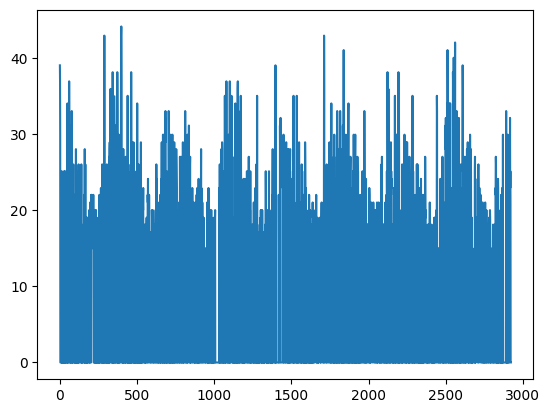

In [359]:
portland.GUST.replace(999.9, 0).plot()

<Axes: >

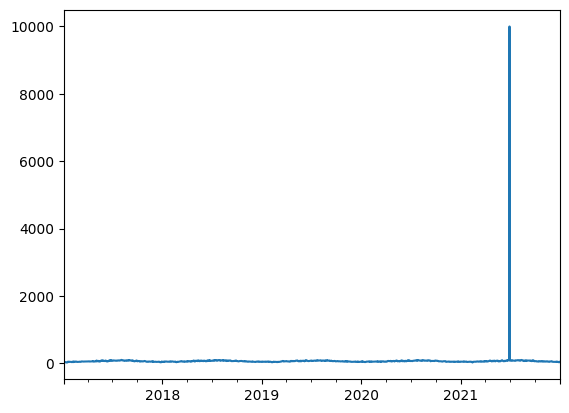

In [304]:
df.MAX_KPDX.plot()

<Axes: >

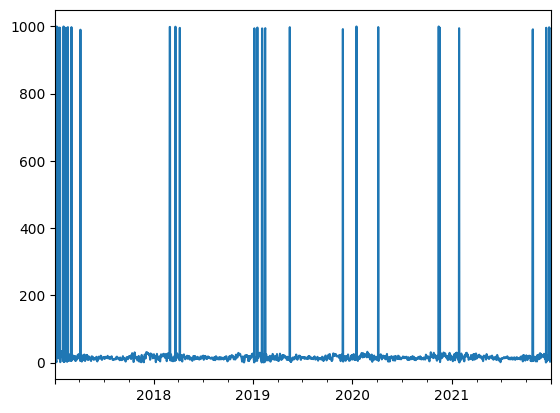

In [296]:
df.STP_KPDX.plot()

In [297]:
df.FRSHTT_KPDX

2017-01-03        0
2017-01-04        0
2017-01-05        0
2017-01-06        0
2017-01-07     1000
              ...  
2021-12-26    11000
2021-12-27    11000
2021-12-28     1000
2021-12-29    11000
2021-12-30    11000
Freq: D, Name: FRSHTT_KPDX, Length: 1823, dtype: int64

In [386]:
import pandas as pd


class ObservationFormatter:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

        self.formatter_map = {
            'TEMP': [self.format_float],
            'DEWP': [self.format_float],
            'MAX': [self.format_float],
            'MIN': [self.format_float],
            'SLP': [self.format_float],
            'STP': [self.format_float],
            'WDSP': [self.format_float],
            'MXSPD': [self.format_float],
            'GUST': [self.format_float, self.replace_value({'999.9': pd.NA})],
            'VISIB': [self.format_float],
            'SNDP': [self.format_float],
            'PRCP': [self.format_float],
            'FRSHTT': [self.format_frshtt],
            'DATE': [self.format_date],
        }

    def format_float(self, df: pd.DataFrame, col_name: str) -> pd.Series:
        col = df[col_name]
        return col.round(2).astype(str).where(col.notnull(), "")

    def format_frshtt(self, df: pd.DataFrame, col_name: str) -> pd.Series:
        col = df[col_name]
        return col.fillna(pd.NA).astype("Int64").astype(str).str.zfill(6).where(col.notnull(), pd.NA)

    def format_date(self, df: pd.DataFrame, col_name: str) -> pd.Series:
        col = df[col_name]
        return pd.to_datetime(col, errors='coerce').dt.strftime('%Y-%m-%d').where(col.notnull(), "")

    def replace_value(self, replacements: dict):
        def _replace_value(df: pd.DataFrame, col_name: str) -> pd.Series:
            return df[col_name].replace(replacements)
        return _replace_value

    def format(self) -> pd.DataFrame:
        for col, formatters in self.formatter_map.items():
            if col in self.df.columns:
                for formatter in formatters:
                    self.df[col] = formatter(df=self.df, col_name=col)

        self.df = self.df.set_index('DATE')
        self.df = self.df.sort_index(ascending=True)
        # expand index to include all dates in the range
        self.df = self.df.reindex(
            pd.date_range(start=self.df.index.min(), end=self.df.index.max()), 
            fill_value=pd.NA
        )

        return self.df


In [387]:
formatter = ObservationFormatter(portland)
formatted_p = formatter.format()

In [388]:
formatted_p.shape

(2923, 31)

In [381]:
formatted_p

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DEWP,DEWP_ATTRIBUTES,FRSHTT,FRSHTT_ATTRIBUTES,GUST,...,SNDP,SNDP_ATTRIBUTES,STP,STP_ATTRIBUTES,TEMP,TEMP_ATTRIBUTES,VISIB,VISIB_ATTRIBUTES,WDSP,WDSP_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,18.1,24,000000,NaN,39.0,...,999.9,NaN,28.2,24,33.9,24,10.0,24,19.8,24
2016-01-02,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,16.1,24,000000,NaN,36.9,...,999.9,NaN,21.1,24,31.8,24,10.0,24,21.8,24
2016-01-03,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,18.0,24,011000,NaN,29.9,...,1.2,NaN,14.1,24,29.4,24,7.9,24,15.3,24
2016-01-04,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,28.0,24,011000,NaN,<NA>,...,1.2,NaN,6.2,24,31.7,24,7.3,24,6.2,24
2016-01-05,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,30.8,24,010000,NaN,<NA>,...,999.9,NaN,998.7,24,34.9,24,8.8,24,3.1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,38.6,24,010000,NaN,22.9,...,999.9,NaN,13.2,24,46.3,24,10.0,24,9.0,24
2023-12-29,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,37.8,24,010000,NaN,25.1,...,999.9,NaN,9.0,24,50.4,24,10.0,24,10.0,24
2023-12-30,72698024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.59578,-122.60919,6.7,40.8,24,010000,NaN,21.0,...,999.9,NaN,9.1,24,48.4,24,9.1,24,10.2,24
